# Titanic: Machine Learning from Disaster

I will apply tools of machine learning to predict which passengers survived the tragety of the sinking of the Titanic.

Idea and data taken from 
https://www.kaggle.com/c/titanic/overview

Coding inspired by https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial and https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html which give great tutorials on how to takle this challenge

In [2]:
## Import all standard dependency modules 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


# Import necessary modules
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
#from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6


In [3]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [4]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("train.csv")
test    = pd.read_csv("test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


In [57]:
# Run the code to see the variables, then read the variable description below to understand them.
titanic

Age        Cabin Embarked      Fare  \
0    22.0          NaN        S    7.2500   
1    38.0          C85        C   71.2833   
2    26.0          NaN        S    7.9250   
3    35.0         C123        S   53.1000   
4    35.0          NaN        S    8.0500   
5     NaN          NaN        Q    8.4583   
6    54.0          E46        S   51.8625   
7     2.0          NaN        S   21.0750   
8    27.0          NaN        S   11.1333   
9    14.0          NaN        C   30.0708   
10    4.0           G6        S   16.7000   
11   58.0         C103        S   26.5500   
12   20.0          NaN        S    8.0500   
13   39.0          NaN        S   31.2750   
14   14.0          NaN        S    7.8542   
15   55.0          NaN        S   16.0000   
16    2.0          NaN        Q   29.1250   
17    NaN          NaN        S   13.0000   
18   31.0          NaN        S   18.0000   
19    NaN          NaN        C    7.2250   
20   35.0          NaN        S   26.0000   
21   34.0          D56        S   13.0000   
22   15.0          NaN        Q    8.0292   
23   28.0           A6        S   35.5000   
24    8.0          NaN        S   21.0750   
25   38.0          NaN        S   31.3875   
26    NaN          NaN        C    7.2250   
27   19.0  C23 C25 C27        S  263.0000   
28    NaN          NaN        Q    7.8792   
29    NaN          NaN        S    7.8958   
..    ...          ...      ...       ...   
861  21.0          NaN        S   11.5000   
862  48.0          D17        S   25.9292   
863   NaN          NaN        S   69.5500   
864  24.0          NaN        S   13.0000   
865  42.0          NaN        S   13.0000   
866  27.0          NaN        C   13.8583   
867  31.0          A24        S   50.4958   
868   NaN          NaN        S    9.5000   
869   4.0          NaN        S   11.1333   
870  26.0          NaN        S    7.8958   
871  47.0          D35        S   52.5542   
872  33.0  B51 B53 B55        S    5.0000   
873  47.0          NaN        S    9.0000   
874  28.0          NaN        C   24.0000   
875  15.0          NaN        C    7.2250   
876  20.0          NaN        S    9.8458   
877  19.0          NaN        S    7.8958   
878   NaN          NaN        S    7.8958   
879  56.0          C50        C   83.1583   
880  25.0          NaN        S   26.0000   
881  33.0          NaN        S    7.8958   
882  22.0          NaN        S   10.5167   
883  28.0          NaN        S   10.5000   
884  25.0          NaN        S    7.0500   
885  39.0          NaN        Q   29.1250   
886  27.0          NaN        S   13.0000   
887  19.0          B42        S   30.0000   
888   NaN          NaN        S   23.4500   
889  26.0         C148        C   30.0000   
890  32.0          NaN        Q    7.7500   

                                                  Name  Parch  PassengerId  \
0                              Braund, Mr. Owen Harris      0            1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                               Heikkinen, Miss. Laina      0            3   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                             Allen, Mr. William Henry      0            5   
5                                     Moran, Mr. James      0            6   
6                              McCarthy, Mr. Timothy J      0            7   
7                       Palsson, Master. Gosta Leonard      1            8   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)      2            9   
9                  Nasser, Mrs. Nicholas (Adele Achem)      0           10   
10                     Sandstrom, Miss. Marguerite Rut      1           11   
11                            Bonnell, Miss. Elizabeth      0           12   
12                      Saundercock, Mr. William Henry      0           13   
13                         Andersson, Mr. Anders Johan      5           14   
14                Vestrom, Miss. Hulda Amanda

PassengerId and Survived are not features but rather a given int to each passenger and survived is a binary value, distinguishing whether or not the passenger survived. 

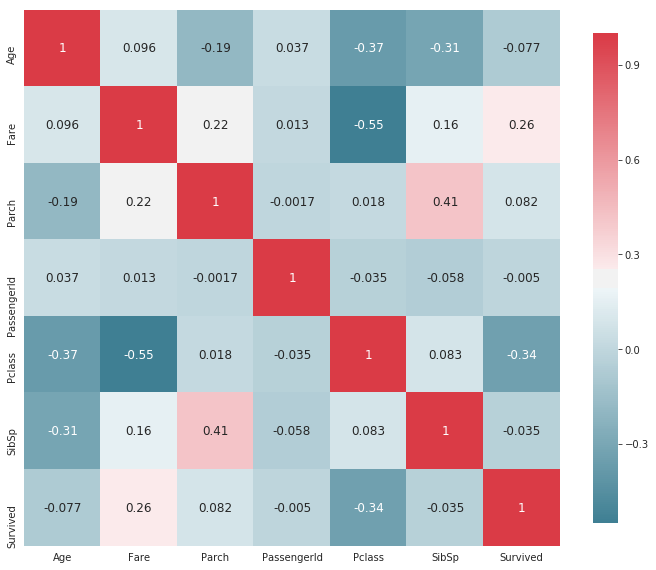

In [7]:
plot_correlation_map( titanic )

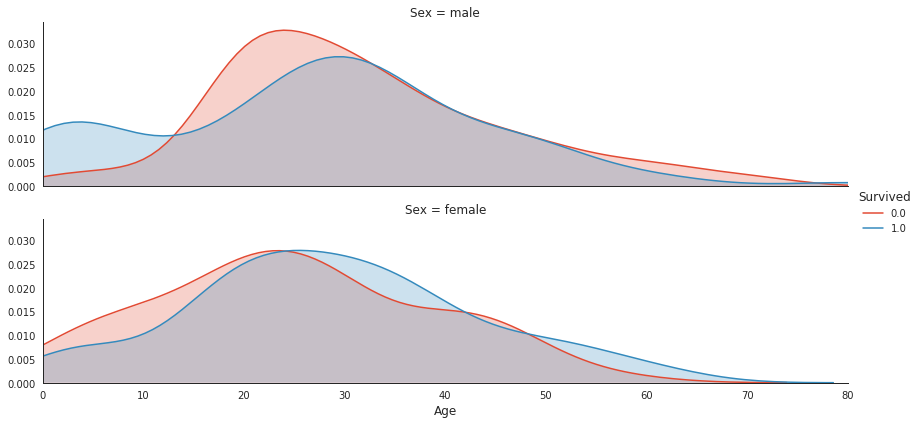

In [8]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

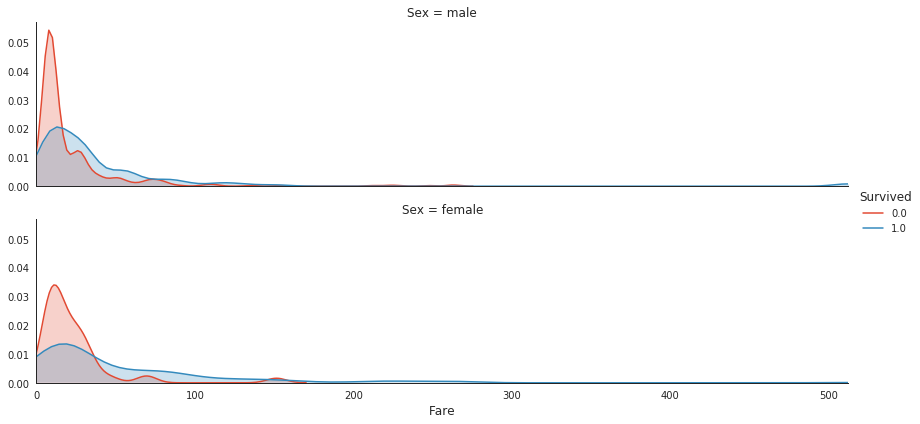

In [11]:
#Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Fare' , target = 'Survived' , row = 'Sex' )

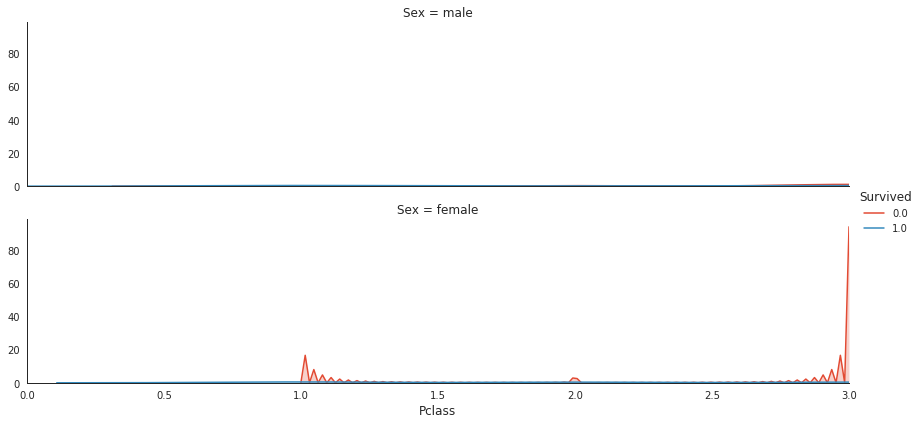

In [13]:
# Plot distributions of Pclass of passangers who survived or did not survive. Not a good variable as
plot_distribution( titanic , var = 'Pclass' , target = 'Survived' , row = 'Sex' )

/home/jack/miniconda3/envs/Python3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


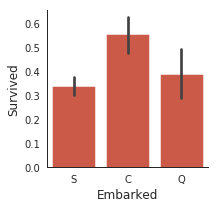

In [9]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )
# What do the black bars represent

/home/jack/miniconda3/envs/Python3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


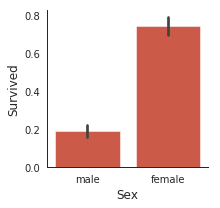

In [14]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

/home/jack/miniconda3/envs/Python3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


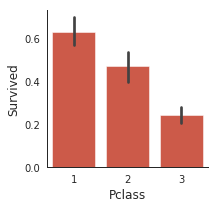

In [15]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

/home/jack/miniconda3/envs/Python3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


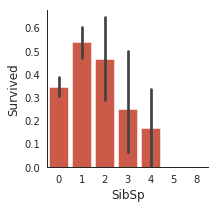

In [16]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

/home/jack/miniconda3/envs/Python3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


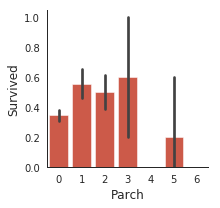

In [17]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Parch' , target = 'Survived' )

In [21]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [22]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

Embarked_C  Embarked_Q  Embarked_S
0           0           0           1
1           1           0           0
2           0           0           1
3           0           0           1
4           0           0           1

In [23]:
# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

Pclass_1  Pclass_2  Pclass_3
0         0         0         1
1         1         0         0
2         0         0         1
3         1         0         0
4         0         0         1

In [39]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()


Age     Fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
3  35.0  53.1000
4  35.0   8.0500

#### Feature Engineering - Creating new Variables


In [40]:
# Extract titles form passanger names, these reflect
# social status and may predict survival probability
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )


# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

Master  Miss  Mr  Mrs  Officer  Royalty
0       0     0   1    0        0        0
1       0     0   0    1        0        0
2       0     1   0    0        0        0
3       0     0   0    1        0        0
4       0     0   1    0        0        0

Some notes: 

A lambda function can take any number of arguments, but can only have one expression. 

Map() is used to apply a function on all the elements of specified iterable and return map object. Python map object is an iterator, so we can iterate over its elements. We can also convert map object to sequence objects such as list, tuple etc. using their factory functions.



In [55]:
# Explore cabin category information from the cabin number
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )


# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

Cabin_A  Cabin_B  Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  \
0        0        0        0        0        0        0        0        0   
1        0        0        1        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        1        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   Cabin_U  
0        1  
1        0  
2        1  
3        0  
4        1

In [56]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

Ticket_A  Ticket_A4  Ticket_A5  Ticket_AQ3  Ticket_AQ4  Ticket_AS  \
0         0          0          1           0           0          0   
1         0          0          0           0           0          0   
2         0          0          0           0           0          0   
3         0          0          0           0           0          0   
4         0          0          0           0           0          0   

   Ticket_C  Ticket_CA  Ticket_CASOTON  Ticket_FC  ...  Ticket_SOTONO2  \
0         0          0               0          0  ...               0   
1         0          0               0          0  ...               0   
2         0          0               0          0  ...               0   
3         0          0               0          0  ...               0   
4         0          0               0          0  ...               0   

   Ticket_SOTONOQ  Ticket_SP  Ticket_STONO  Ticket_STONO2  Ticket_STONOQ  \
0               0          0             0              0              0   
1               0          0             0              0              0   
2               0          0             0              1              0   
3               0          0             0              0              0   
4               0          0             0              0              0   

   Ticket_SWPP  Ticket_WC  Ticket_WEP  Ticket_XXX  
0            0          0           0           0  
1            0          0           0           0  
2            0          0           0           0  
3            0          0           0           1  
4            0          0           0           1  

[5 rows x 37 columns]